# README
Adjust `Timesteps` and `feature_used` as noted.
---

In [1]:
from util_input_output_model import *
from collections import defaultdict
from datetime import timedelta
import tensorflow as tf
import numpy as np
import pandas as pd
import time
provinces = ['Bangkok','Chanthaburi','Chiang Mai','Kanchanaburi','Songkhla','Khon Kaen']

features = ['PM2.5','WindDir','Wind Speed(km/h)','Temp(C)','Cambodia_frp','Myanmar_frp','Thailand_frp','Lao_PDR_frp']
tf.__version__

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


'2.5.0-rc1'

In [2]:
# Province and its model
province = 'Bangkok'
path = "./Models/Bangkok_run_2021_04_25-08_23_07.h5"

# Feature used
feature_used = features[:4]

# Number of timesteps
timesteps = 720

model = tf.keras.models.load_model(path)
print(model.layers[0].input_shape)
print(model.summary())

(None, 720, 3)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200)               163200    
_________________________________________________________________
dense (Dense)                (None, 144)               28944     
_________________________________________________________________
dropout (Dropout)            (None, 144)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 72)                10440     
Total params: 202,584
Trainable params: 202,584
Non-trainable params: 0
_________________________________________________________________
None


## Prepare data

In [3]:
Train_data, X_train, Y_train = prepare_train_data(timesteps, feature_used = feature_used)
Test_data, X_test, Y_test = prepare_test_data(Train_data, timesteps, feature_used = feature_used)

dif : 715
2019-03-18 08:00:00
base = 2019-03-18 12:00:00
dif : 709
2019-03-18 08:00:00
base = 2019-03-18 18:00:00
dif : 703
2019-03-18 08:00:00
base = 2019-03-19 00:00:00
dif : 697
2019-03-18 08:00:00
base = 2019-03-19 06:00:00


## Scale data

In [4]:
x_train_scalers, y_train_scalers, X_train_scaled, Y_train_scaled = scale_data(X_train, Y_train, Train_data)
x_test_scalers, y_test_scalers, X_test_scaled, Y_test_scaled = scale_data(X_test, Y_test, Test_data)

## Check the shape

In [5]:
x_, y_ = {}, {}

for p in provinces:
    x_[p] = {"Train": np.array(X_train_scaled[p]),
             "Test": np.array(X_test_scaled[p])}
    
    y_[p] = {"Train": np.array(Y_train_scaled[p]).squeeze(axis=2),
             "Test": np.array(Y_test_scaled[p]).squeeze(axis=2)}

    print(p)
    print(f'X Train: {x_[p]["Train"].shape}')
    print(f'Y Train: {y_[p]["Train"].shape}')
    print(f'X Test: {x_[p]["Test"].shape}')
    print(f'Y Test: {y_[p]["Test"].shape}\n')

Bangkok
X Train: (4306, 720, 3)
Y Train: (4306, 72)
X Test: (1454, 720, 3)
Y Test: (1454, 72)

Chanthaburi
X Train: (4306, 720, 3)
Y Train: (4306, 72)
X Test: (1454, 720, 3)
Y Test: (1454, 72)

Chiang Mai
X Train: (4306, 720, 3)
Y Train: (4306, 72)
X Test: (1454, 720, 3)
Y Test: (1454, 72)

Kanchanaburi
X Train: (4306, 720, 3)
Y Train: (4306, 72)
X Test: (1454, 720, 3)
Y Test: (1454, 72)

Songkhla
X Train: (4306, 720, 3)
Y Train: (4306, 72)
X Test: (1454, 720, 3)
Y Test: (1454, 72)

Khon Kaen
X Train: (1876, 720, 3)
Y Train: (1876, 72)
X Test: (1454, 720, 3)
Y Test: (1454, 72)



## Assign variables

In [6]:
x_feed, y_feed = x_[province]['Train'], y_[province]['Train']
x_eval, y_eval = x_[province]['Test'], y_[province]['Test']

In [7]:
# Last check for null values
print(np.isnan(x_feed).any())
print(np.isnan(y_feed).any())
print(np.isnan(x_eval).any())
print(np.isnan(y_eval).any())

False
False
False
False


## Evaluation

In [8]:
model.evaluate(x_eval, y_eval)

46/46 [==============================] - 42s 884ms/step - loss: 0.0194


0.019365893676877022

In [9]:
from sklearn.metrics import mean_squared_error as mse
pred = model(x_eval)
rmse = []
print('province :', province)
for i in range(len(pred)):
    p = y_test_scalers[province].inverse_transform(pred[i].numpy().reshape((-1,1)))
    y_t = y_test_scalers[province].inverse_transform(y_eval[i].reshape((-1,1)))
    rmse.append(np.sqrt(mse(p, y_t)))
np.mean(rmse)

province : Bangkok


12.929412089287109

province = Bangkok


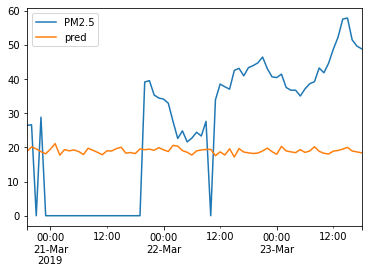

In [10]:
i = 9
print('province =',province)
h = y_test_scalers[province].inverse_transform(pred[i].numpy().reshape((-1,1)))
k = Y_test[province][i].copy()
k['pred'] = h
k.plot();